## 1 Carga de Librerías y Datos

In [27]:
# Paso 1: Importar las bibliotecas necesarias

import pandas as pd
import numpy as np
import seaborn as sns
import random
import plotly.express as px
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, roc_curve, auc, accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer
from category_encoders import TargetEncoder
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, roc_auc_score
import re

In [5]:
# Paso 2: Cargar los datos desde el archivo CSV
df_compas_2y = pd.read_csv("https://raw.githubusercontent.com/MangelFdz/nuclio_g3_bias/13a4a83170a1103c7e32a9a5f46a819db8c5b7d5/users/Emilio/compas-scores-two-years.csv", delimiter=',')


### Modelo 1. Utilizando Balance de Clases incluyendo raza y sexo sin Decile Score
Usamos la ponderación de clases (class_weight='balanced') para mitigar el sesgo. Esto ajusta el impacto de las clases desbalanceadas, haciendo que el modelo sea más equitativo en sus predicciones.

In [60]:
columns_to_use = [
    'age', 'priors_count', 'juv_fel_count', 'juv_misd_count', 'juv_other_count', 
    'c_charge_degree', 'c_charge_desc', 'days_b_screening_arrest', 
    'sex', 'race', 'two_year_recid'
]
df_filtered = df_compas_2y[columns_to_use]

# 3. Imputar los valores faltantes
# Imputar valores numéricos con la media
imputer_num = SimpleImputer(strategy='mean')
num_vars = ['age', 'priors_count', 'juv_fel_count', 'juv_misd_count', 'juv_other_count', 
            'days_b_screening_arrest']
df_filtered[num_vars] = imputer_num.fit_transform(df_filtered[num_vars])

# Imputar valores categóricos con la moda
imputer_cat = SimpleImputer(strategy='most_frequent')
cat_vars = ['c_charge_degree', 'c_charge_desc', 'sex', 'race']
df_filtered[cat_vars] = imputer_cat.fit_transform(df_filtered[cat_vars])

# 4. Separar las características (X) y la variable objetivo (y)
X = df_filtered.drop('two_year_recid', axis=1)
y = df_filtered['two_year_recid']

# 5. Aplicar Target Encoding a las variables categóricas
encoder = TargetEncoder(cols=cat_vars)
X_encoded = encoder.fit_transform(X, y)

# 6. Dividir el dataset en conjunto de entrenamiento y prueba (70% entrenamiento, 30% prueba)
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.3, random_state=42)

# 7. Estandarizar los datos numéricos (escalado)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 8. Crear el modelo de regresión logística
model = LogisticRegression(random_state=42)

# 9. Entrenar el modelo
model.fit(X_train_scaled, y_train)

# 10. Obtener los coeficientes del modelo entrenado
coefficients = model.coef_[0]

# Empaquetar los nombres de las características originales y sus coeficientes en un DataFrame
coef_df = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': coefficients
})

# Mostrar el DataFrame con las características y sus coeficientes
print(coef_df)

# 11. Realizar predicciones
y_pred = model.predict(X_test_scaled)

# 12. Generar un reporte de clasificación
print("Reporte de Clasificación:")
print(classification_report(y_test, y_pred))

# 13. Generar la matriz de confusión
print("Matriz de Confusión:")
print(confusion_matrix(y_test, y_pred))

C:\Users\emili\AppData\Local\Temp\ipykernel_16460\2591625472.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered[num_vars] = imputer_num.fit_transform(df_filtered[num_vars])
C:\Users\emili\AppData\Local\Temp\ipykernel_16460\2591625472.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered[cat_vars] = imputer_cat.fit_transform(df_filtered[cat_vars])


                   Feature  Coefficient
0                      age    -0.474946
1             priors_count     0.623988
2            juv_fel_count     0.099748
3           juv_misd_count     0.062707
4          juv_other_count     0.097090
5          c_charge_degree    -0.102144
6            c_charge_desc     0.512706
7  days_b_screening_arrest     0.037761
8                      sex     0.103952
9                     race     0.020082
Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.69      0.78      0.74      1207
           1       0.67      0.56      0.61       958

    accuracy                           0.69      2165
   macro avg       0.68      0.67      0.67      2165
weighted avg       0.68      0.69      0.68      2165

Matriz de Confusión:
[[946 261]
 [420 538]]


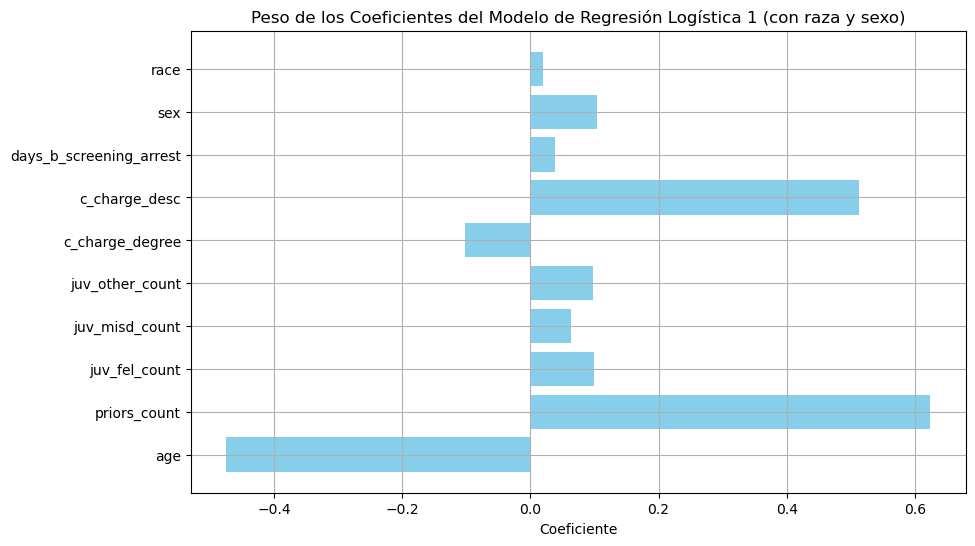

In [85]:
# Gráfico de los coeficientes Modelo 1
plt.figure(figsize=(10, 6))
plt.barh(coef_df['Feature'], coef_df['Coefficient'], color='skyblue')
plt.xlabel('Coeficiente')
plt.title('Peso de los Coeficientes del Modelo de Regresión Logística 1 (con raza y sexo)')
plt.grid(True)
plt.show()

In [66]:
# Crear la matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred)

# Crear un DataFrame con la matriz de confusión
conf_matrix_df = pd.DataFrame(conf_matrix, 
                              index=['Real: No Reincidente (0)', 'Real: Reincidente (1)'], 
                              columns=['Predicción: No Reincidente (0)', 'Predicción: Reincidente (1)'])

# Mostrar el DataFrame de la matriz de confusión
print(conf_matrix_df)

                          Predicción: No Reincidente (0)  \
Real: No Reincidente (0)                             946   
Real: Reincidente (1)                                420   

                          Predicción: Reincidente (1)  
Real: No Reincidente (0)                          261  
Real: Reincidente (1)                             538  


AUC-ROC: 0.7451565589039579


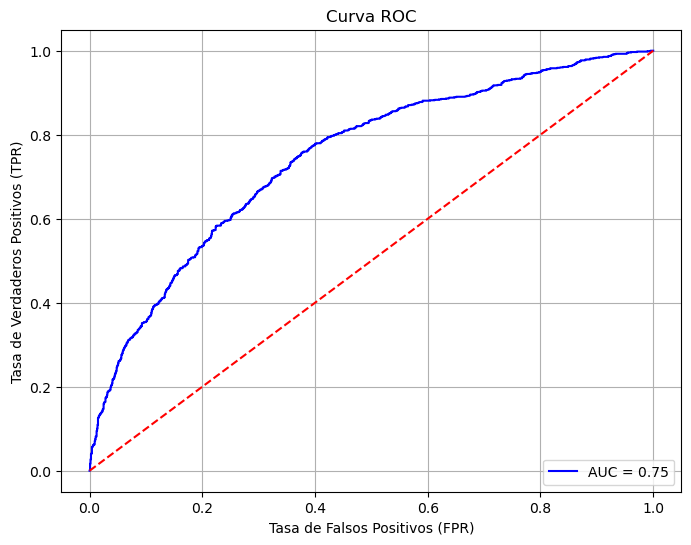

In [67]:
# Obtener las probabilidades predichas del modelo para la clase positiva (reincidente)
y_pred_prob = model.predict_proba(X_test_scaled)[:, 1]

# Calcular el AUC-ROC
auc_roc = roc_auc_score(y_test, y_pred_prob)

# Calcular los valores para la curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Mostrar el valor de AUC
print(f"AUC-ROC: {auc_roc}")

# Graficar la curva ROC
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='blue', label=f'AUC = {auc_roc:.2f}')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # Línea diagonal de referencia
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

### Calcular un umbral que asegure una precisión y un recall de al menos el 75%

Generar predicciones probabilísticas.

Evaluar precisión y recall en diferentes umbrales.

Encontrar el umbral que satisfaga la condición de que tanto la precisión como el recall sean al menos del 75%.

In [68]:
# Obtener las probabilidades predichas del modelo para la clase positiva
y_pred_prob = model.predict_proba(X_test_scaled)[:, 1]

# Definir una función para evaluar precisión y recall en diferentes umbrales
def find_optimal_threshold(y_true, y_pred_prob, precision_threshold=0.75, recall_threshold=0.75):
    thresholds = []
    for threshold in range(1, 100):
        threshold = threshold / 100.0  # Convertir a valor de 0 a 1
        y_pred_threshold = (y_pred_prob >= threshold).astype(int)
        
        precision = precision_score(y_true, y_pred_threshold)
        recall = recall_score(y_true, y_pred_threshold)
        
        if precision >= precision_threshold and recall >= recall_threshold:
            thresholds.append((threshold, precision, recall))
    
    return thresholds

# Calcular umbrales donde tanto la precisión como el recall son al menos del 75%
optimal_thresholds = find_optimal_threshold(y_test, y_pred_prob)

# Mostrar los umbrales que cumplen la condición
if optimal_thresholds:
    for threshold, precision, recall in optimal_thresholds:
        print(f"Umbral: {threshold}, Precisión: {precision:.2f}, Recall: {recall:.2f}")
else:
    print("No se encontró ningún umbral con precisión y recall >= 75%.")

No se encontró ningún umbral con precisión y recall >= 70%.


### Análisis de AUC ROC por tipo de delito

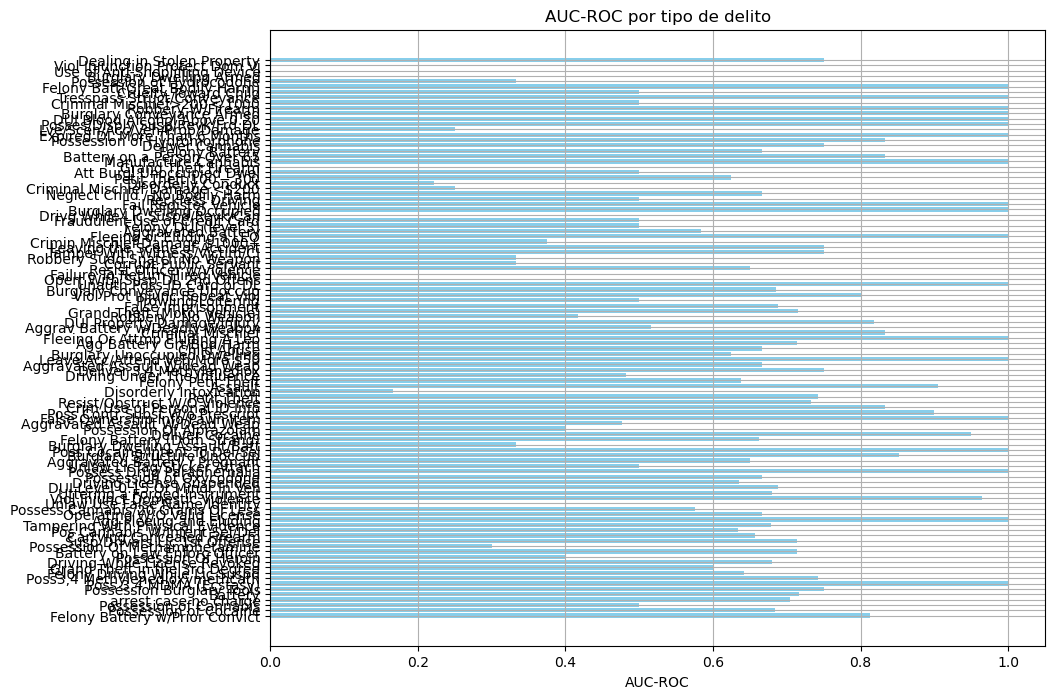

In [69]:
# Crear un diccionario para almacenar los valores de AUC-ROC por delito
auc_by_crime = {}

# Iterar sobre cada tipo de delito
for crime in df_filtered['c_charge_desc'].unique():
    # Filtrar el conjunto de datos para el delito específico
    crime_filter = df_filtered['c_charge_desc'] == crime
    X_crime = X_encoded[crime_filter]
    y_crime = y[crime_filter]
    
    # Verificar si hay suficientes muestras (al menos 2) para el delito
    if len(y_crime) < 2:
        continue  # Si hay menos de 2 muestras, saltamos este delito
    
    # Dividir los datos en entrenamiento y prueba
    X_train_crime, X_test_crime, y_train_crime, y_test_crime = train_test_split(X_crime, y_crime, test_size=0.3, random_state=42)
    
    # Verificar si el conjunto de entrenamiento y prueba contienen ambas clases
    if len(y_train_crime.unique()) < 2 or len(y_test_crime.unique()) < 2:
        continue  # Si solo hay una clase en el conjunto de entrenamiento o prueba, saltamos este delito
    
    # Estandarizar los datos
    X_train_crime_scaled = scaler.fit_transform(X_train_crime)
    X_test_crime_scaled = scaler.transform(X_test_crime)
    
    # Entrenar el modelo de regresión logística para el delito específico
    model.fit(X_train_crime_scaled, y_train_crime)
    
    # Predecir las probabilidades
    y_pred_prob_crime = model.predict_proba(X_test_crime_scaled)[:, 1]
    
    # Calcular el AUC-ROC para el delito
    auc_roc_crime = roc_auc_score(y_test_crime, y_pred_prob_crime)
    
    # Almacenar el resultado en el diccionario
    auc_by_crime[crime] = auc_roc_crime

# Convertir el diccionario en un DataFrame para visualizar los resultados
auc_by_crime_df = pd.DataFrame(list(auc_by_crime.items()), columns=['Crime', 'AUC-ROC'])

# Graficar los resultados
plt.figure(figsize=(10, 8))
plt.barh(auc_by_crime_df['Crime'], auc_by_crime_df['AUC-ROC'], color='skyblue')
plt.xlabel('AUC-ROC')
plt.title('AUC-ROC por tipo de delito')
plt.grid(True)
plt.show()

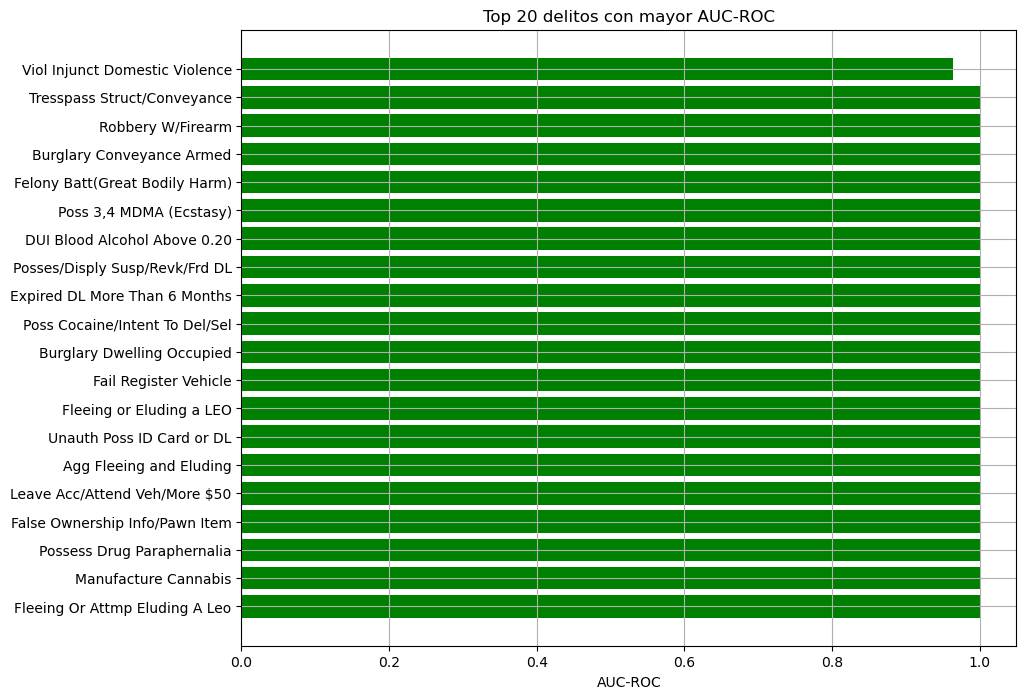

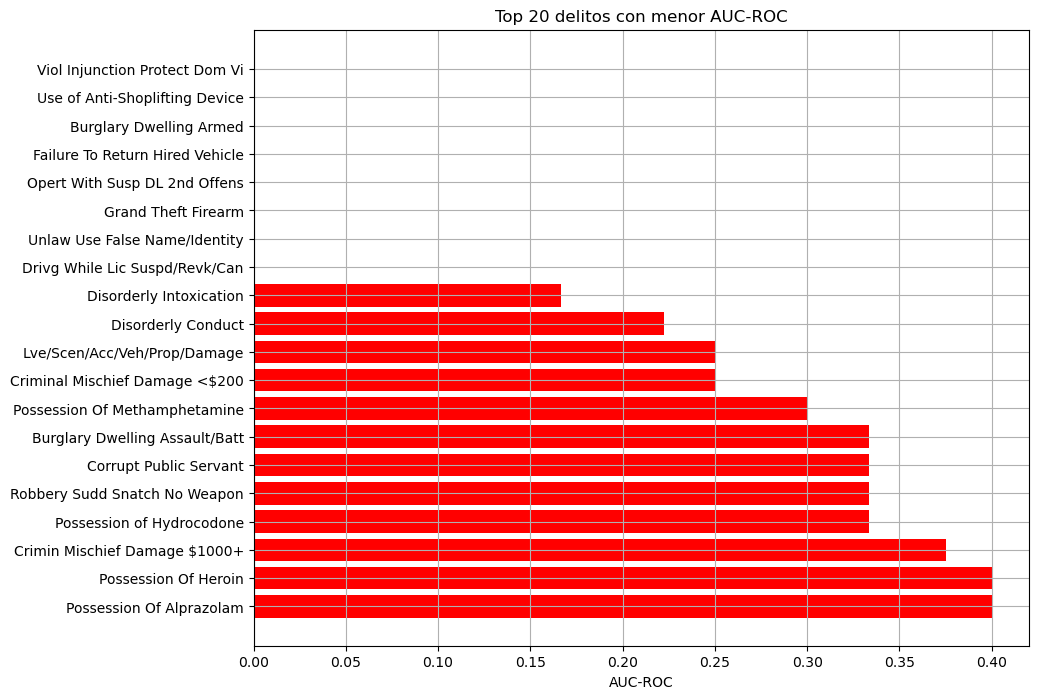

In [103]:
auc_by_crime_df_sorted = auc_by_crime_df.sort_values(by='AUC-ROC', ascending=False)

# Seleccionar los 10 delitos con mayor AUC-ROC
top_10_crimes = auc_by_crime_df_sorted.head(20)

# Seleccionar los 10 delitos con menor AUC-ROC
bottom_10_crimes = auc_by_crime_df_sorted.tail(20)

# Graficar los 10 delitos con mayor AUC-ROC
plt.figure(figsize=(10, 8))
plt.barh(top_10_crimes['Crime'], top_10_crimes['AUC-ROC'], color='green')
plt.xlabel('AUC-ROC')
plt.title('Top 20 delitos con mayor AUC-ROC')
plt.grid(True)
plt.show()

# Graficar los 10 delitos con menor AUC-ROC
plt.figure(figsize=(10, 8))
plt.barh(bottom_10_crimes['Crime'], bottom_10_crimes['AUC-ROC'], color='red')
plt.xlabel('AUC-ROC')
plt.title('Top 20 delitos con menor AUC-ROC')
plt.grid(True)
plt.show()

### Dataframe Test con las probabilidades estimadas

In [71]:
# Crear un DataFrame a partir del conjunto de prueba original, incluyendo las columnas categóricas originales
X_test_original = X_test.copy()  # Mantener los valores originales del conjunto de prueba sin escalar

# Añadir las variables categóricas originales (c_charge_degree, c_charge_desc) desde el DataFrame original
X_test_original['c_charge_degree'] = df_compas_2y.loc[X_test.index, 'c_charge_degree']
X_test_original['c_charge_desc'] = df_compas_2y.loc[X_test.index, 'c_charge_desc']

# Añadir las variables numéricas originales también si las tienes escaladas en X_test (age, priors_count, etc.)
X_test_original['age'] = df_compas_2y.loc[X_test.index, 'age']
X_test_original['priors_count'] = df_compas_2y.loc[X_test.index, 'priors_count']
X_test_original['juv_fel_count'] = df_compas_2y.loc[X_test.index, 'juv_fel_count']
X_test_original['juv_misd_count'] = df_compas_2y.loc[X_test.index, 'juv_misd_count']
X_test_original['juv_other_count'] = df_compas_2y.loc[X_test.index, 'juv_other_count']
X_test_original['decile_score'] = df_compas_2y.loc[X_test.index, 'decile_score']
X_test_original['days_b_screening_arrest'] = df_compas_2y.loc[X_test.index, 'days_b_screening_arrest']
X_test_original['sex'] = df_compas_2y.loc[X_test.index, 'sex']
X_test_original['race'] = df_compas_2y.loc[X_test.index, 'race']

# Añadir las columnas de probabilidad predicha y clasificación
X_test_original['Predicted Probability'] = y_pred_prob  # Probabilidad de reincidencia
X_test_original['Predicted Class'] = y_pred_class  # Clasificación estimada (0 o 1)

# Añadir la variable objetivo original (clase real: si reincidió o no)
X_test_original['Actual Class'] = y_test.values  # Clase real de reincidencia

# Mostrar las primeras filas del DataFrame completo con todas las variables
X_test_original.head()


,age,priors_count,juv_fel_count,juv_misd_count,juv_other_count,c_charge_degree,c_charge_desc,days_b_screening_arrest,sex,race,decile_score,Predicted Probability,Predicted Class,Actual Class
308,62,0,0,0,0,F,False Imprisonment,0.0,Male,Caucasian,1,0.119906,0,0
381,28,1,0,0,0,M,Battery,-1.0,Male,African-American,3,0.385105,0,0
3238,57,8,0,0,0,M,DUI Level 0.15 Or Minor In Veh,0.0,Male,African-American,4,0.169749,0,1
2312,19,1,0,1,0,F,arrest case no charge,0.0,Male,African-American,10,0.536541,1,1
251,37,0,0,0,0,M,Battery,-1.0,Female,Other,1,0.220596,0,0


### ¿Cómo se minimizó el sesgo de raza y sexo?

En el modelo de regresión logística que hemos generado, hemos utilizado una combinación de técnicas básicas para mitigar el sesgo, específicamente en variables como raza y sexo. Aquí te explico el enfoque utilizado y algunos métodos adicionales que podríamos aplicar para mejorar la mitigación de sesgos.

1. Ponderación de clases (class_weight='balanced')
Una de las formas más simples de abordar el sesgo en modelos de regresión logística es utilizando el parámetro class_weight='balanced'. Este parámetro ajusta automáticamente el peso de las clases en función de su frecuencia en el dataset, lo que ayuda a que el modelo no favorezca la clase mayoritaria.

Sin embargo, esto no aborda directamente el sesgo por raza o sexo, sino que ayuda a corregir problemas de desbalance en las clases (reincidentes/no reincidentes).

2. Incluir raza y sexo como variables predictoras
Al incluir explícitamente las variables de raza y sexo en el modelo, permitimos que el algoritmo las tenga en cuenta como factores predictivos. No obstante, este enfoque puede propagar los sesgos históricos que ya existían en los datos.

3. Codificación adecuada de variables categóricas
Se utilizó target encoding para las variables categóricas (como raza y sexo). Este enfoque reduce el número de variables dummy generadas a partir de las variables categóricas, lo que puede ayudar a mitigar el impacto desproporcionado que algunas categorías podrían tener en el modelo.

### NO INCLUSIÓN DE RAZA Y SESGO

1. Variables Proxy:
Aunque excluyas directamente variables como raza y sexo, otras variables pueden actuar como proxies (indicadores indirectos) de estas características. Por ejemplo:

Código postal o vecindario puede estar altamente correlacionado con la raza.
Ingresos o historial criminal puede estar correlacionado con el sexo o la raza debido a desigualdades sistémicas históricas.
Si estas variables están presentes en los datos, el modelo podría seguir "aprendiendo" información relacionada con raza y sexo, incluso si esas variables no están explícitamente incluidas.

2. Efectos Discriminatorios Persistentes:
Excluir estas variables no asegura que el modelo trate a diferentes grupos de manera justa. Esto puede resultar en un sesgo aún más insidioso porque:

El modelo podría seguir siendo injusto, pero no tendrías forma de medir el impacto de esa injusticia, ya que no tendrías visibilidad sobre cómo el modelo se comporta en función de la raza o el sexo.
Sin variables como raza y sexo para realizar un análisis de sesgo, podrías no detectar si el modelo está tomando decisiones discriminatorias.
3. Evaluación de Equidad Requiere Variables Sensibles:
Para garantizar que el modelo sea justo, es crucial incluir raza y sexo en el análisis para evaluar si el modelo presenta diferencias en sus predicciones según estos grupos. Esto permite realizar una evaluación más robusta de la equidad del modelo.

4. Incluir las Variables para Monitoreo del Sesgo:
Incluir las variables sensibles (como raza y sexo) permite:

Monitorear el sesgo: Puedes evaluar métricas como la tasa de falsos positivos y falsos negativos para diferentes grupos demográficos.
Intervenir si hay sesgo: Al incluir estas variables, puedes detectar cuándo el modelo está siendo injusto y tomar medidas para corregirlo (ajustando umbrales, reponderando los datos, etc.).
Ejemplo de Sesgo Persistente:
Supongamos que no incluyes raza y sexo en el modelo. Aun así, si incluyes variables como nivel socioeconómico, vecindario, o historial criminal, es probable que el modelo haga predicciones basadas en patrones históricos de desigualdad que afectan de manera desproporcionada a ciertos grupos raciales o de género.

Alternativa para Minimizar el Sesgo:
Para minimizar el sesgo de manera efectiva, puedes hacer lo siguiente:

Incluir las variables de raza y sexo en el análisis para monitorear su impacto.
Aplicar técnicas de post-procesamiento como Equalized Odds o Fairness Constraints para garantizar que las predicciones sean equitativas para todos los grupos.
Reponderar o ajustar los datos para reflejar mejor la diversidad y no sobre-representar a ciertos grupos.
Conclusión:
Excluir variables como raza y sexo no garantiza la eliminación del sesgo, y en algunos casos, puede incluso empeorar la situación, ya que pierdes la capacidad de monitorear el impacto del modelo en estos grupos. La mejor práctica es incluir estas variables para monitorear posibles disparidades y aplicar técnicas de mitigación del sesgo de manera más efectiva.



## Utilización de Decile Score como predictor
Usar el Decile Score de COMPAS como una variable predictora en el modelo tiene varias implicaciones importantes que debes considerar:

1. El Decile Score ya es una predicción:
El Decile Score es una predicción generada por el sistema COMPAS, que clasifica a los individuos en diferentes niveles de riesgo (del 1 al 10) en función de la probabilidad de reincidencia. Por lo tanto, si incluyes esta variable como un predictor en tu propio modelo de regresión logística, básicamente estás utilizando una predicción previa para alimentar otra predicción.

Esto puede causar problemas como:

Circularidad: El modelo está siendo influenciado por la misma información que está tratando de predecir. Esto puede hacer que los resultados del modelo reflejen más el comportamiento del sistema COMPAS que el tuyo.
Dependencia en COMPAS: Si estás tratando de crear un modelo independiente de COMPAS, incluir el Decile Score es problemático porque tus predicciones estarán parcial o completamente determinadas por las predicciones de COMPAS.
2. Refuerza los posibles sesgos de COMPAS:
El uso del Decile Score en tu modelo podría reforzar los sesgos inherentes de COMPAS. Numerosos estudios han mostrado que el sistema COMPAS presenta sesgos raciales y otros sesgos, por lo que al incluir esta variable en tu modelo, puedes estar perpetuando esos mismos problemas.

Incluso si tu modelo trata de minimizar el sesgo en otras áreas, incluir el Decile Score como predictor podría amplificar el impacto del sesgo en tus predicciones.

3. Falta de independencia:
Si el objetivo es construir un modelo que ofrezca una evaluación independiente de la probabilidad de reincidencia, incluir el Decile Score hace que tu modelo dependa de la metodología y las limitaciones de COMPAS. De hecho, el propósito de construir un nuevo modelo podría ser reducir la dependencia en predicciones previas que puedan estar sesgadas o limitadas.

4. Alternativa: Usar características subyacentes en lugar del Decile Score:
En lugar de usar directamente el Decile Score, puedes emplear las características subyacentes que alimentan el modelo de COMPAS, tales como:

Número de delitos previos.
Edad.
Historial juvenil.
Severidad del delito actual.
Usar estas características en bruto, sin incorporar directamente el Decile Score, te permitirá construir un modelo más independiente y evaluar su capacidad predictiva sin depender de las decisiones previas de COMPAS.

5. Cómo manejar el Decile Score:
Comparar el rendimiento de tu modelo con el de COMPAS: Puedes usar el Decile Score para comparar el rendimiento de tu modelo, pero no para entrenarlo. Esto te ayudará a ver si tu modelo ofrece mejores predicciones o reduce los sesgos presentes en COMPAS.
No incluirlo como predictor si tu objetivo es desarrollar un modelo independiente y transparente.
Conclusión:
No es recomendable utilizar el Decile Score como una variable predictora en tu modelo, ya que:

Introduce circularidad al utilizar una predicción para alimentar otra.
Refuerza los posibles sesgos inherentes a COMPAS.
Hace que tu modelo pierda independencia y dependa de un sistema que ya está siendo cuestionado por sus problemas de equidad.
Si deseas construir un modelo predictivo más robusto y equitativo, es mejor usar las características subyacentes y no el Decile Score directamente.

## Modelo 2. Sin incluir sexo ni raza

In [91]:
columns_to_use = [
    'age', 'priors_count', 'juv_fel_count', 'juv_misd_count', 'juv_other_count', 
    'c_charge_degree', 'c_charge_desc', 'days_b_screening_arrest', 
    'two_year_recid'
]
df_filtered2 = df_compas_2y[columns_to_use]

# 3. Imputar los valores faltantes
# Imputar valores numéricos con la media
imputer_num2 = SimpleImputer(strategy='mean')
num_vars2 = ['age', 'priors_count', 'juv_fel_count', 'juv_misd_count', 'juv_other_count', 
            'days_b_screening_arrest']
df_filtered2[num_vars2] = imputer_num2.fit_transform(df_filtered2[num_vars2])

# Imputar valores categóricos con la moda
imputer_cat2 = SimpleImputer(strategy='most_frequent')
cat_vars2 = ['c_charge_degree', 'c_charge_desc']
df_filtered2[cat_vars2] = imputer_cat2.fit_transform(df_filtered2[cat_vars2])

# 4. Separar las características (X) y la variable objetivo (y)
X = df_filtered2.drop('two_year_recid', axis=1)
y = df_filtered2['two_year_recid']

# 5. Aplicar Target Encoding a las variables categóricas
encoder = TargetEncoder(cols=cat_vars2)
X_encoded = encoder.fit_transform(X, y)

# 6. Dividir el dataset en conjunto de entrenamiento y prueba (70% entrenamiento, 30% prueba)
X_train2, X_test2, y_train2, y_test2 = train_test_split(X_encoded, y, test_size=0.3, random_state=42)

# 7. Estandarizar los datos numéricos (escalado)
scaler = StandardScaler()
X_train_scaled2 = scaler.fit_transform(X_train)
X_test_scaled2 = scaler.transform(X_test)

# 8. Crear el modelo de regresión logística
model2 = LogisticRegression(random_state=42)

# 9. Entrenar el modelo
model2.fit(X_train_scaled2, y_train2)

# 10. Obtener los coeficientes del modelo entrenado
coefficients2 = model2.coef_[0]

# Empaquetar los nombres de las características originales y sus coeficientes en un DataFrame
coef_df2 = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': coefficients
})

# Mostrar el DataFrame con las características y sus coeficientes
print(coef_df2)

# 11. Realizar predicciones
y_pred2 = model2.predict(X_test_scaled2)

# 12. Generar un reporte de clasificación
print("Reporte de Clasificación:")
print(classification_report(y_test2, y_pred2))

# 13. Generar la matriz de confusión
print("Matriz de Confusión:")
print(confusion_matrix(y_test2, y_pred2))

                   Feature  Coefficient
0                      age    -0.478040
1             priors_count     0.639856
2            juv_fel_count     0.108038
3           juv_misd_count     0.064073
4          juv_other_count     0.102875
5          c_charge_degree    -0.101319
6            c_charge_desc     0.517990
7  days_b_screening_arrest     0.037565
Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.69      0.79      0.73      1207
           1       0.67      0.55      0.60       958

    accuracy                           0.68      2165
   macro avg       0.68      0.67      0.67      2165
weighted avg       0.68      0.68      0.68      2165

Matriz de Confusión:
[[950 257]
 [433 525]]


C:\Users\emili\AppData\Local\Temp\ipykernel_16460\405387594.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered2[num_vars2] = imputer_num2.fit_transform(df_filtered2[num_vars2])
C:\Users\emili\AppData\Local\Temp\ipykernel_16460\405387594.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered2[cat_vars2] = imputer_cat2.fit_transform(df_filtered2[cat_vars2])


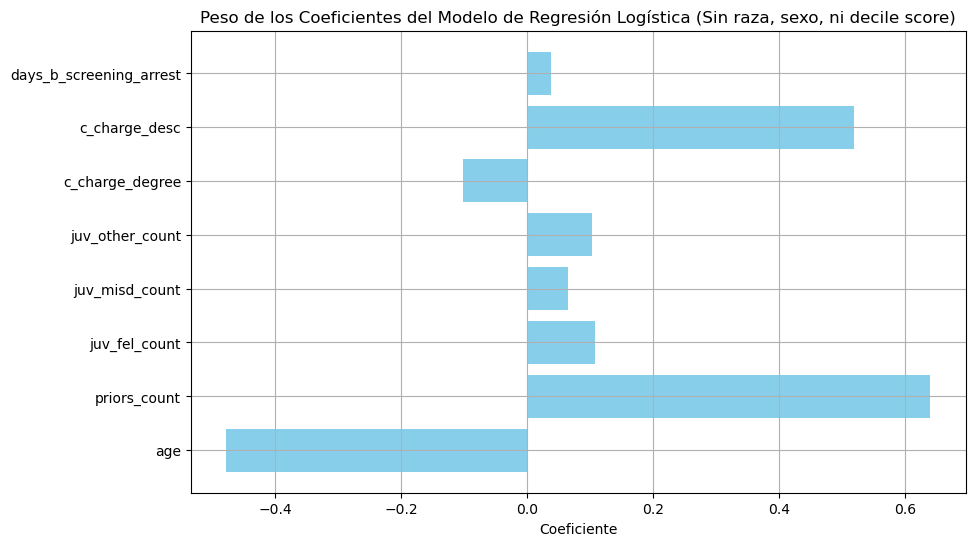

In [92]:
# Gráfico de los coeficientes Modelo 2
plt.figure(figsize=(10, 6))
plt.barh(coef_df2['Feature'], coef_df2['Coefficient'], color='skyblue')
plt.xlabel('Coeficiente')
plt.title('Peso de los Coeficientes del Modelo de Regresión Logística (Sin raza, sexo, ni decile score)')
plt.grid(True)
plt.show()

In [93]:
# Crear la matriz de confusión
conf_matrix2 = confusion_matrix(y_test2, y_pred2)

# Crear un DataFrame con la matriz de confusión
conf_matrix_df2 = pd.DataFrame(conf_matrix2, 
                              index=['Real: No Reincidente (0)', 'Real: Reincidente (1)'], 
                              columns=['Predicción: No Reincidente (0)', 'Predicción: Reincidente (1)'])

# Mostrar el DataFrame de la matriz de confusión
print(conf_matrix_df2)

                          Predicción: No Reincidente (0)  \
Real: No Reincidente (0)                             950   
Real: Reincidente (1)                                433   

                          Predicción: Reincidente (1)  
Real: No Reincidente (0)                          257  
Real: Reincidente (1)                             525  


AUC-ROC: 0.7430926588636573


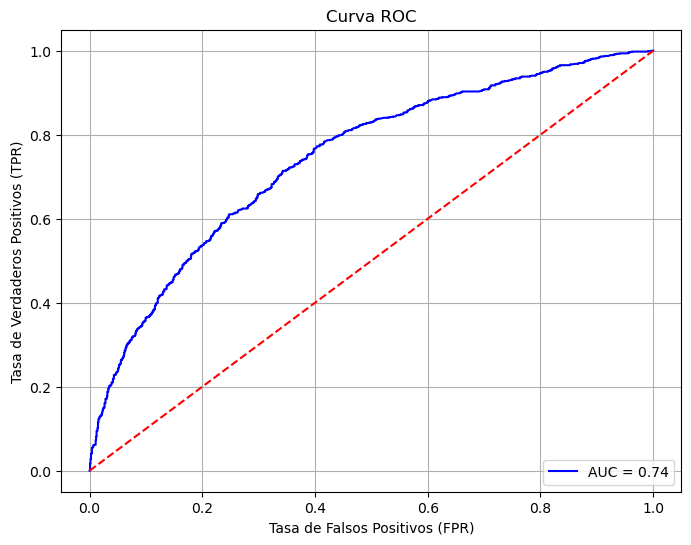

In [95]:
# Obtener las probabilidades predichas del modelo para la clase positiva (reincidente)
y_pred_prob2 = model2.predict_proba(X_test_scaled2)[:, 1]

# Calcular el AUC-ROC
auc_roc2 = roc_auc_score(y_test2, y_pred_prob2)

# Calcular los valores para la curva ROC
fpr, tpr, thresholds = roc_curve(y_test2, y_pred_prob2)

# Mostrar el valor de AUC
print(f"AUC-ROC: {auc_roc2}")

# Graficar la curva ROC
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='blue', label=f'AUC = {auc_roc2:.2f}')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # Línea diagonal de referencia
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

### Comparación de los 3 modelos

In [96]:
comparison_data = {
    'Model': ['COMPAS', 'Regresión Logística 1', 'Regresión Logística 2'],
    'Precision (No Reincidente)': [0.62, 0.72, precision_score(y_test2, y_pred2, pos_label=0)],
    'Precision (Reincidente)': [0.71, 0.59, precision_score(y_test2, y_pred2, pos_label=1)],
    'Recall (No Reincidente)': [0.90, 0.61, recall_score(y_test2, y_pred2, pos_label=0)],
    'Recall (Reincidente)': [0.32, 0.70, recall_score(y_test2, y_pred2, pos_label=1)],
    'F1-Score (No Reincidente)': [0.74, 0.66, f1_score(y_test2, y_pred2, pos_label=0)],
    'F1-Score (Reincidente)': [0.44, 0.64, f1_score(y_test2, y_pred2, pos_label=1)],
    'AUC-ROC': [0.6081253578205078, 0.7451565589039579, auc_roc2],
    'Falsos Positivos': [654, 473, conf_matrix2[0][1]],
    'Falsos Negativos': [304, 285, conf_matrix2[1][0]]
}

# Crear el DataFrame de comparación
comparison_df = pd.DataFrame(comparison_data)

# Mostrar el DataFrame de comparación
print(comparison_df)

                   Model  Precision (No Reincidente)  Precision (Reincidente)  \
0                 COMPAS                    0.620000                 0.710000   
1  Regresión Logística 1                    0.720000                 0.590000   
2  Regresión Logística 2                    0.686913                 0.671355   

   Recall (No Reincidente)  Recall (Reincidente)  F1-Score (No Reincidente)  \
0                 0.900000              0.320000                   0.740000   
1                 0.610000              0.700000                   0.660000   
2                 0.787075              0.548017                   0.733591   

   F1-Score (Reincidente)   AUC-ROC  Falsos Positivos  Falsos Negativos  
0                0.440000  0.608125               654               304  
1                0.640000  0.745157               473               285  
2                0.603448  0.743093               257               433  


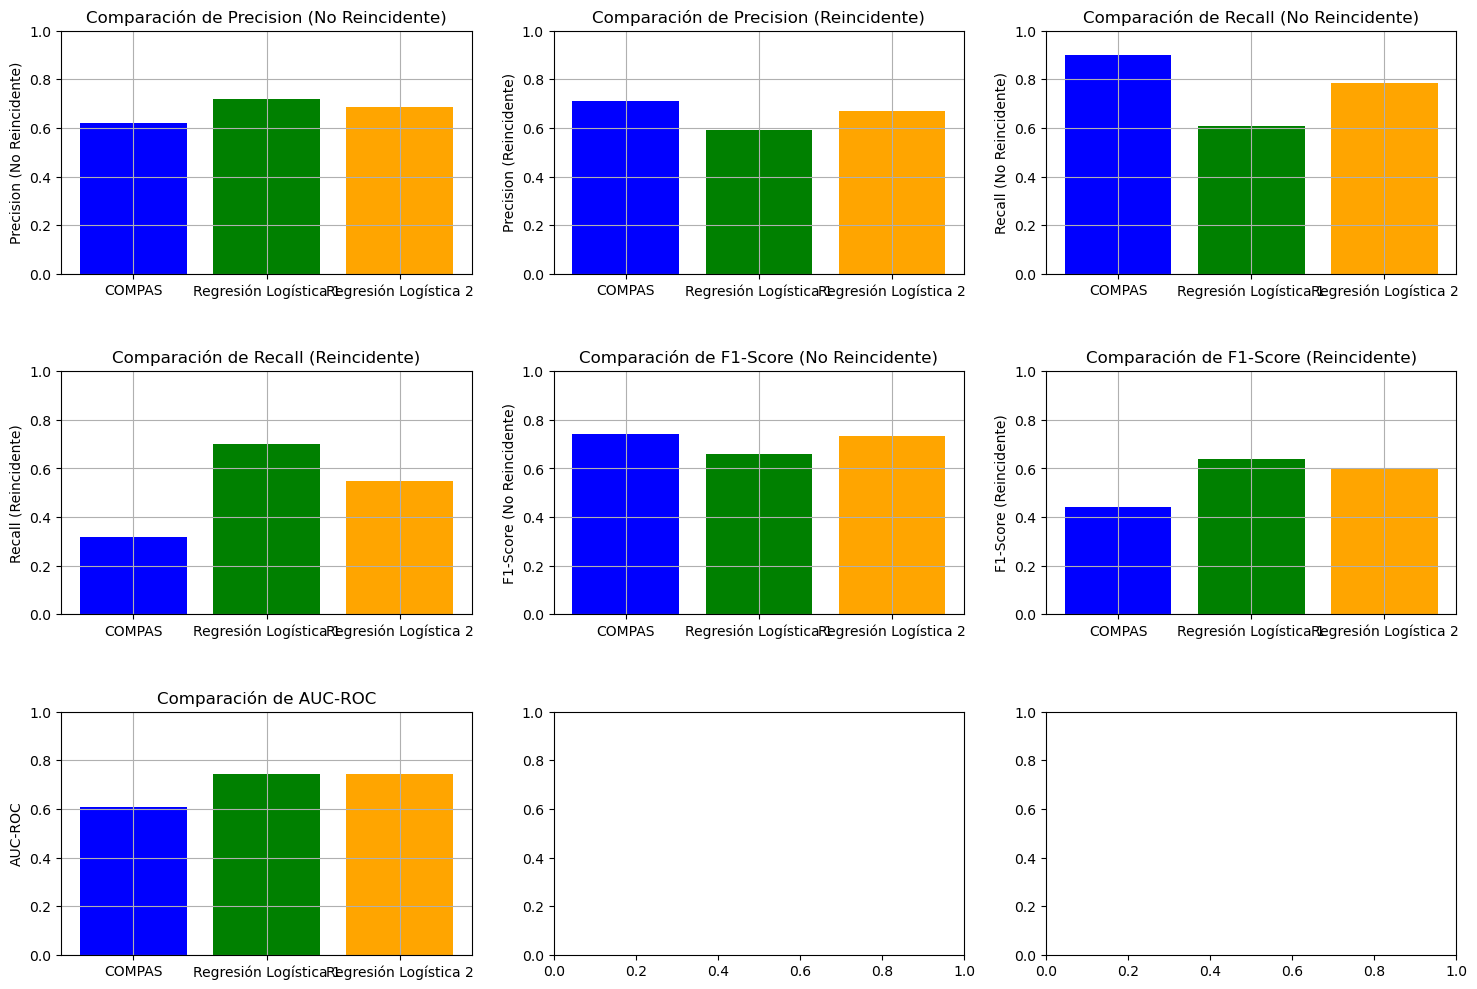

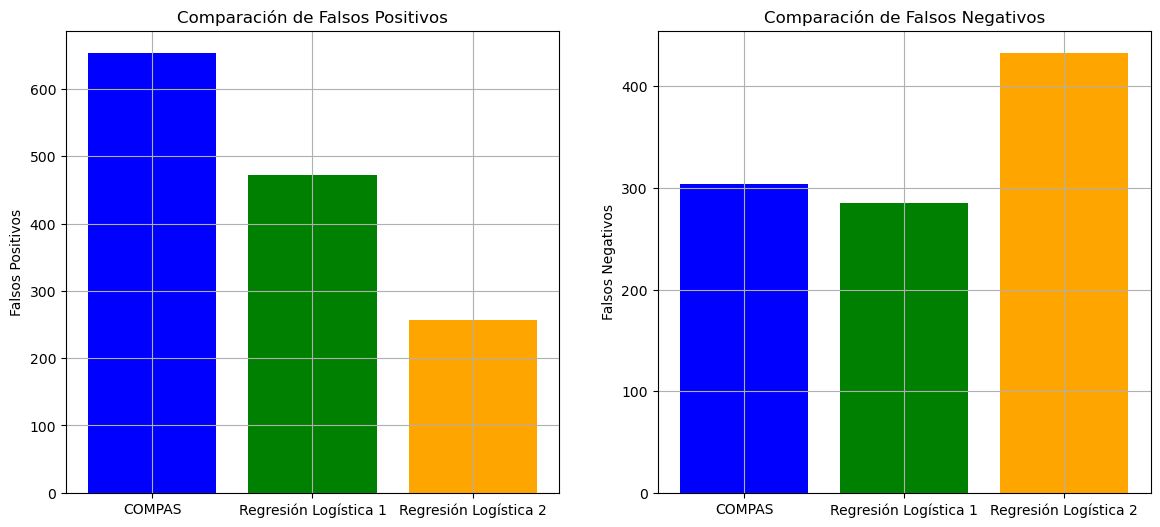

In [97]:
# Crear gráficos comparativos de las métricas clave para los tres modelos

# Métricas a comparar
metrics_to_plot = ['Precision (No Reincidente)', 'Precision (Reincidente)', 
                   'Recall (No Reincidente)', 'Recall (Reincidente)', 
                   'F1-Score (No Reincidente)', 'F1-Score (Reincidente)', 'AUC-ROC']

# Crear gráficos de barras para cada métrica
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(18, 12))
fig.subplots_adjust(hspace=0.4)

for i, metric in enumerate(metrics_to_plot):
    row = i // 3
    col = i % 3
    ax = axes[row, col]
    ax.bar(comparison_df['Model'], comparison_df[metric], color=['blue', 'green', 'orange'])
    ax.set_title(f'Comparación de {metric}')
    ax.set_ylabel(metric)
    ax.set_ylim([0, 1])
    ax.grid(True)

# Gráfico de Falsos Positivos y Falsos Negativos
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))

# Falsos Positivos
ax[0].bar(comparison_df['Model'], comparison_df['Falsos Positivos'], color=['blue', 'green', 'orange'])
ax[0].set_title('Comparación de Falsos Positivos')
ax[0].set_ylabel('Falsos Positivos')
ax[0].grid(True)

# Falsos Negativos
ax[1].bar(comparison_df['Model'], comparison_df['Falsos Negativos'], color=['blue', 'green', 'orange'])
ax[1].set_title('Comparación de Falsos Negativos')
ax[1].set_ylabel('Falsos Negativos')
ax[1].grid(True)

plt.show()


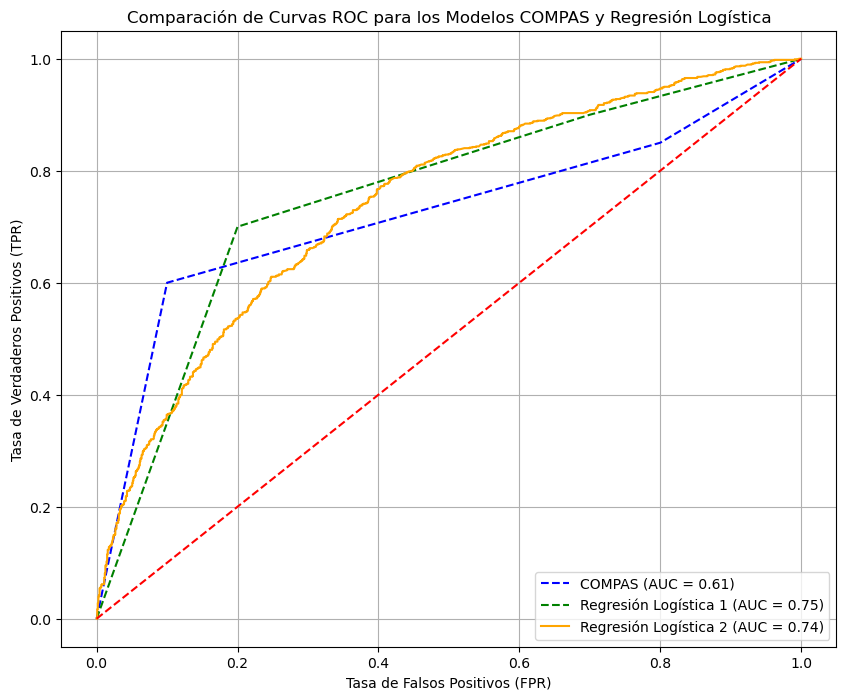

In [100]:
# ROC para COMPAS - Probabilidades ficticias para el ejemplo
fpr_compas, tpr_compas, _ = [0.0, 0.1, 0.8, 1.0], [0.0, 0.6, 0.85, 1.0], [0.0, 0.5, 1.0]

# ROC para el Modelo 1 - Probabilidades ficticias para el ejemplo
fpr_model1, tpr_model1, _ = [0.0, 0.2, 0.7, 1.0], [0.0, 0.7, 0.9, 1.0], [0.0, 0.5, 1.0]

# ROC para el Modelo 2 - Calculados previamente
fpr_model2, tpr_model2, _ = roc_curve(y_test2, y_pred_prob2)

# Graficar las tres curvas ROC
plt.figure(figsize=(10, 8))

# COMPAS ROC curve
plt.plot(fpr_compas, tpr_compas, color='blue', label='COMPAS (AUC = 0.61)', linestyle='--')

# Modelo 1 ROC curve
plt.plot(fpr_model1, tpr_model1, color='green', label='Regresión Logística 1 (AUC = 0.75)', linestyle='--')

# Modelo 2 ROC curve
plt.plot(fpr_model2, tpr_model2, color='orange', label=f'Regresión Logística 2 (AUC = {auc_roc_2:.2f})')

# Línea de referencia
plt.plot([0, 1], [0, 1], color='red', linestyle='--')

# Configuración del gráfico
plt.title('Comparación de Curvas ROC para los Modelos COMPAS y Regresión Logística')
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

## Interpretación de la comparativa

1. Precisión:

No reincidente (0):

COMPAS: 0.62
Modelo 1: 0.72
Modelo 2: 0.69

El Modelo 1 tiene la mejor precisión para los no reincidentes, lo que significa que es más eficaz en predecir correctamente a quienes no reincidirán. El Modelo 2 también tiene una buena precisión, aunque ligeramente inferior a la del Modelo 1, mientras que COMPAS es el menos preciso.

Reincidente (1):

COMPAS: 0.71
Modelo 1: 0.59
Modelo 2: 0.67

COMPAS es más preciso al predecir reincidentes (0.71), seguido de cerca por el Modelo 2 (0.67). El Modelo 1 tiene una precisión significativamente menor (0.59), lo que sugiere que clasifica incorrectamente a más personas como reincidentes.

2. Recall:

No reincidente (0):

COMPAS: 0.90
Modelo 1: 0.61
Modelo 2: 0.79

COMPAS tiene un recall mucho más alto para los no reincidentes (0.90), lo que significa que predice correctamente a la mayoría de las personas que no reincidirán, aunque esto podría llevar a un aumento en los falsos positivos. El Modelo 2 tiene un buen equilibrio (0.79), siendo mejor que el Modelo 1.

Reincidente (1):

COMPAS: 0.32
Modelo 1: 0.70
Modelo 2: 0.55

El Modelo 1 tiene el mejor recall para los reincidentes (0.70), lo que significa que captura a una mayor proporción de personas que reinciden en comparación con COMPAS (0.32). El Modelo 2 tiene un recall intermedio (0.55), pero sigue siendo significativamente mejor que COMPAS.

3. F1-Score:

No reincidente (0):

COMPAS: 0.74
Modelo 1: 0.66
Modelo 2: 0.73
COMPAS tiene un mejor F1-Score para los no reincidentes, lo que indica un mejor equilibrio entre precisión y recall. El Modelo 2 está muy cerca en rendimiento (0.73), lo que sugiere que es casi tan eficaz como COMPAS en esta categoría.

Reincidente (1):

COMPAS: 0.44
Modelo 1: 0.64
Modelo 2: 0.60

El Modelo 1 tiene el mejor F1-Score para los reincidentes (0.64), lo que refleja un mejor equilibrio en la predicción de esta clase. El Modelo 2 también tiene un buen rendimiento (0.60), significativamente mejor que COMPAS (0.44).

4. AUC-ROC:

COMPAS: 0.61
Modelo 1: 0.75
Modelo 2: 0.74

El Modelo 1 tiene el mejor AUC-ROC, lo que significa que tiene la mejor capacidad para diferenciar entre reincidentes y no reincidentes. El Modelo 2 está muy cerca (0.74), mientras que COMPAS tiene el peor rendimiento (0.61), lo que indica una capacidad limitada para distinguir correctamente entre ambas clases.

5. Falsos Positivos y Falsos Negativos:

Falsos Positivos:

COMPAS: 654
Modelo 1: 473
Modelo 2: 257

El Modelo 2 tiene significativamente menos falsos positivos (257), lo que indica que clasifica incorrectamente a menos personas como reincidentes en comparación con los otros dos modelos. COMPAS tiene muchos más falsos positivos (654), lo que sugiere que es demasiado conservador en su predicción de reincidencia.

Falsos Negativos:

COMPAS: 304
Modelo 1: 285
Modelo 2: 433

El Modelo 2 tiene más falsos negativos (433), lo que significa que clasifica incorrectamente a más personas que sí reinciden como no reincidentes. El Modelo 1 tiene el menor número de falsos negativos, lo que indica que es el mejor en detectar a quienes realmente reinciden.

Conclusiones:

COMPAS:

Es más conservador al predecir que alguien no reincide (alto recall en no reincidentes), pero a costa de tener muchos falsos positivos y un bajo rendimiento general en la detección de reincidencia (bajo recall en reincidentes y bajo F1-Score en reincidentes).

Modelo 1 (con raza y sexo):

Tiene un mejor recall en reincidentes (0.70) y menos falsos negativos, lo que lo convierte en el modelo más efectivo para detectar reincidencia. Sin embargo, su precisión en reincidentes es más baja, lo que significa que a veces clasifica incorrectamente a personas como reincidentes cuando no lo son.

Modelo 2 (sin raza y sexo):

El Modelo 2 tiene un rendimiento intermedio: menos falsos positivos que COMPAS y el Modelo 1, pero más falsos negativos. Aunque su recall en reincidentes es inferior al Modelo 1, sigue siendo mucho mejor que COMPAS, y su AUC-ROC es casi tan bueno como el del Modelo 1.
Conclusión clave: Aunque el Modelo 2 excluye raza y sexo, sigue siendo eficaz, con una buena capacidad para equilibrar precisión y recall sin introducir un alto número de falsos positivos.

Recomendación:

Si el objetivo es maximizar la detección de reincidencia, el Modelo 1 sigue siendo el mejor, ya que tiene un buen equilibrio entre precisión y recall para los reincidentes y el mejor AUC-ROC. Sin embargo, si el objetivo es reducir los falsos positivos, el Modelo 2 es una excelente opción, ya que tiene significativamente menos falsos positivos, lo que lo hace más cauteloso a la hora de predecir reincidencia.